In [4]:
import sys
sys.path.append('../')

import os
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
from utils.dataset import display_two_volumes, display_volumes, segment_body, min_max_normalization
from utils.preprocess import anisotropic_diffusion_denoise_3d, bilateral_filter_3d, clahe_3d

# To allow auto reload to this notebook after modifying any external file imported
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
subject = 'copd1'
reference_image_path = os.path.join(os.getcwd(),f'../dataset/train/{subject}/{subject}_eBHCT.nii.gz') # _lung

In [6]:
copd1_eBHCT = sitk.ReadImage(reference_image_path)

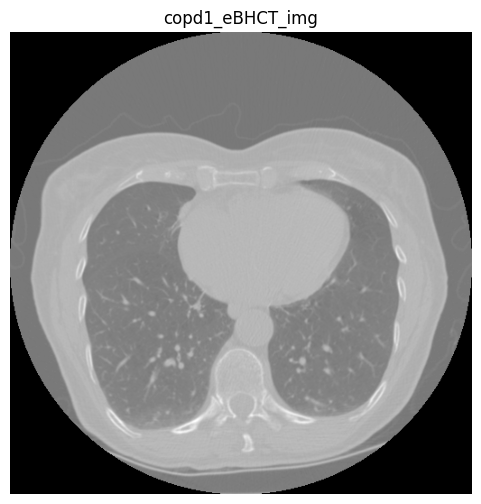

In [7]:
copd1_eBHCT_img = sitk.GetArrayFromImage(copd1_eBHCT)
display_volumes(copd1_eBHCT_img, title1='copd1_eBHCT_img', slice1 = 80)

#### Exploring Filtering

##### 1. Anisotropic Diffusion Filter

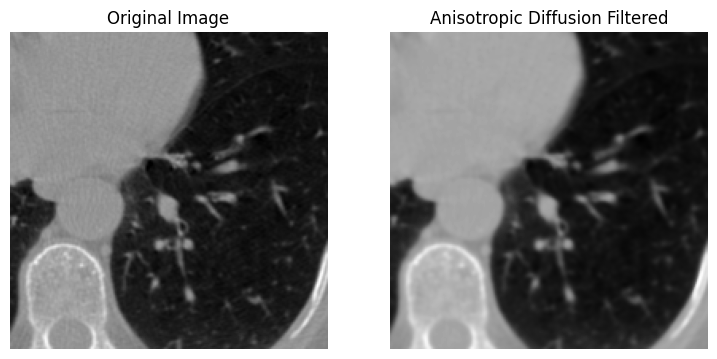

In [8]:
conductance_parameter = 3.0 
time_step = 0.0625 
number_of_iterations = 5 

output_image = anisotropic_diffusion_denoise_3d(copd1_eBHCT, conductance_parameter, time_step, number_of_iterations)
output_anisotropic_image = sitk.GetArrayFromImage(output_image)

# display_two_volumes(output_anisotropic_image, title1='output_anisotropic_image', slice1 = 70)
display_two_volumes(copd1_eBHCT_img[:, 220:420, 220:420], output_anisotropic_image[:, 220:420, 220:420], 'Original Image', 'Anisotropic Diffusion Filtered', slice=70)
# display_two_volumes(copd1_eBHCT_img[:, :, :], output_anisotropic_image[:, :, :], 'Original Image', 'anisotropic_diffusion Filtered', slice=70)

##### 2. Bilateral Filter

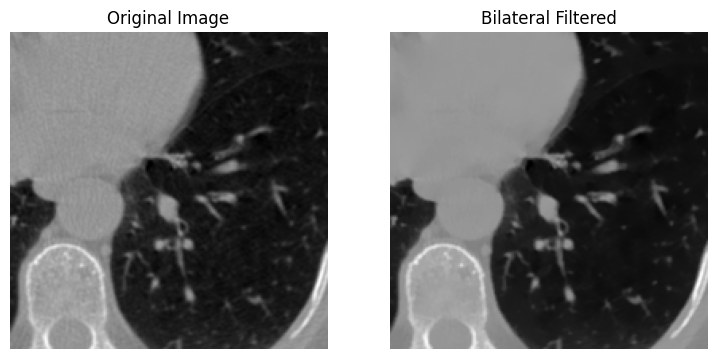

In [9]:
domain_sigma = 2.0 
range_sigma = 50.0 

output_image = bilateral_filter_3d(copd1_eBHCT, domain_sigma, range_sigma)
output_bilateral_filter_image = sitk.GetArrayFromImage(output_image)

display_two_volumes(copd1_eBHCT_img[:, 220:420, 220:420], output_bilateral_filter_image[:, 220:420, 220:420], 'Original Image', 'Bilateral Filtered', slice=70)

#### Exploring Contrast Enhancing

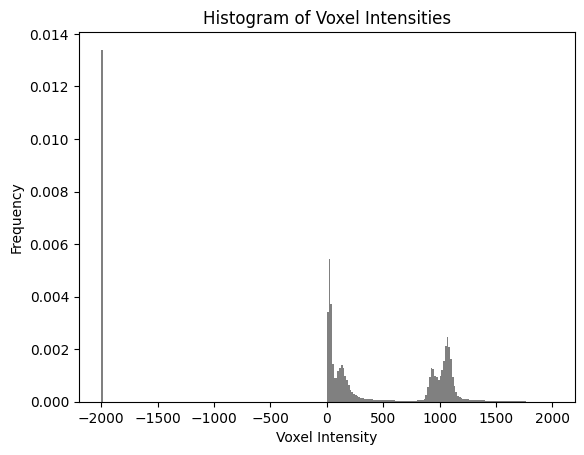

In [5]:
# Flatten the image to a 1D array
copd1_eBHCT_flattened = copd1_eBHCT_img.flatten()
# copd1_eBHCT_flattened = copd1_eBHCT_flattened[copd1_eBHCT_flattened > -2000]

# Plot the histogram
plt.hist(copd1_eBHCT_flattened, bins=256, range=(-2000, 2000), density=True, color='gray', alpha=1)
plt.title('Histogram of Voxel Intensities')
plt.xlabel('Voxel Intensity')
plt.ylabel('Frequency')
plt.show()

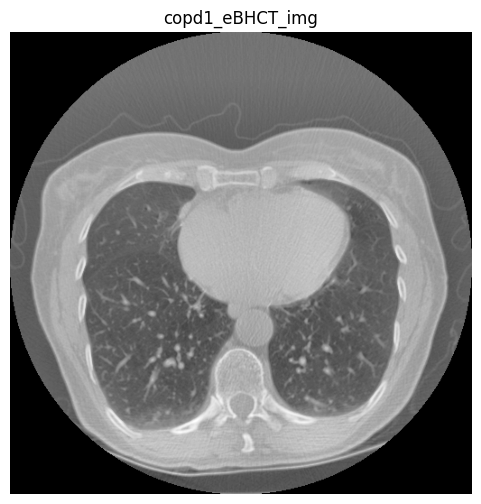

In [23]:
copd1_eBHCT_enhanced = clahe_3d(copd1_eBHCT)

copd1_eBHCT_enhanced_img = sitk.GetArrayFromImage(copd1_eBHCT_enhanced)
display_volumes(copd1_eBHCT_enhanced_img, title1='copd1_eBHCT_img', slice1 = 80)

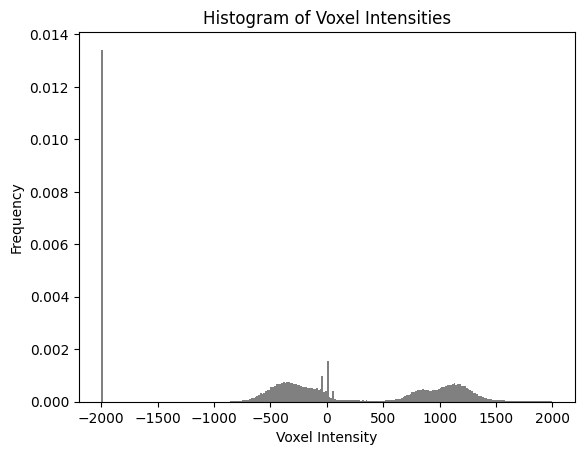

In [24]:
# Flatten the image to a 1D array
copd1_eBHCT_enhanced = sitk.GetArrayFromImage(copd1_eBHCT_enhanced)
copd1_eBHCT_enhanced_flattened = copd1_eBHCT_enhanced.flatten()

# Plot the histogram
plt.hist(copd1_eBHCT_enhanced_flattened, bins=256, range=(-2000, 2000), density=True, color='gray', alpha=1)
plt.title('Histogram of Voxel Intensities')
plt.xlabel('Voxel Intensity')
plt.ylabel('Frequency')
plt.show()

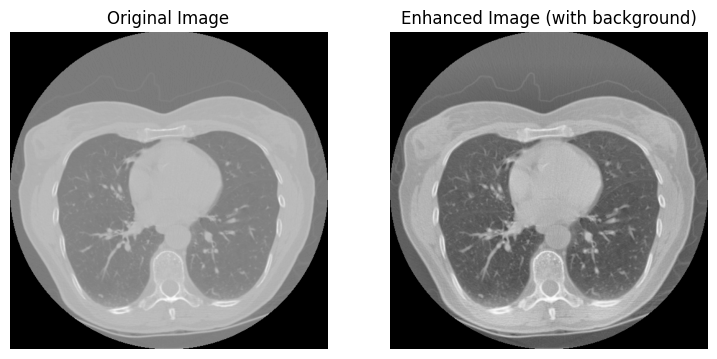

In [25]:
display_two_volumes(copd1_eBHCT_img, copd1_eBHCT_enhanced, 'Original Image', 'Enhanced Image (with background)', slice=70)

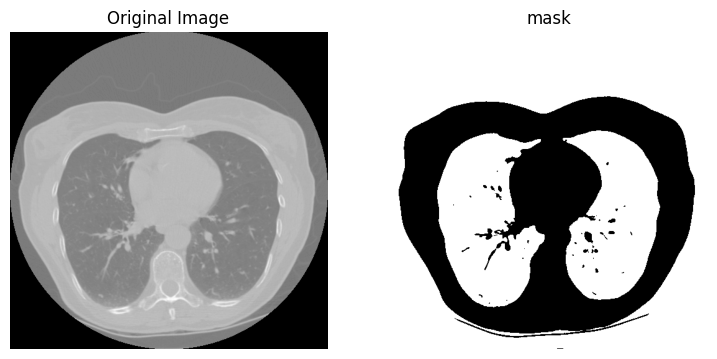

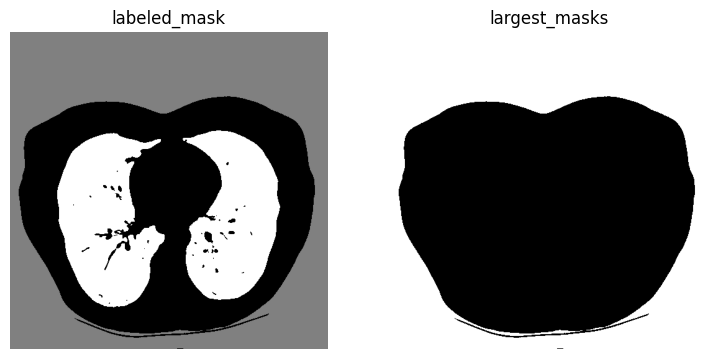

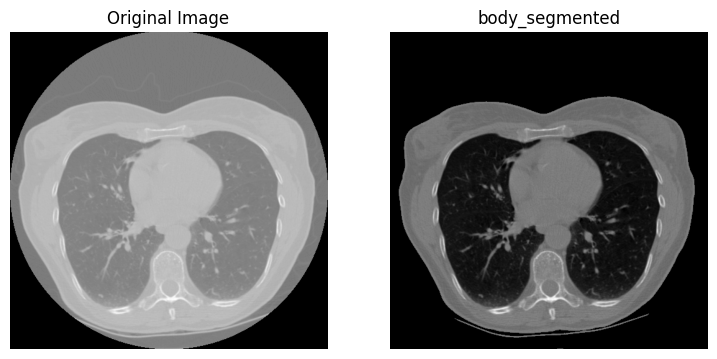

In [68]:
mask, labeled_mask, largest_masks, body_segmented = \
    segment_body(copd1_eBHCT_img, threshold=700)

slice = 70
display_two_volumes(copd1_eBHCT_img, mask, 'Original Image', 'mask', slice)
display_two_volumes(labeled_mask, largest_masks, 'labeled_mask', 'largest_masks', slice)
display_two_volumes(copd1_eBHCT_img, body_segmented, 'Original Image', 'body_segmented', slice)

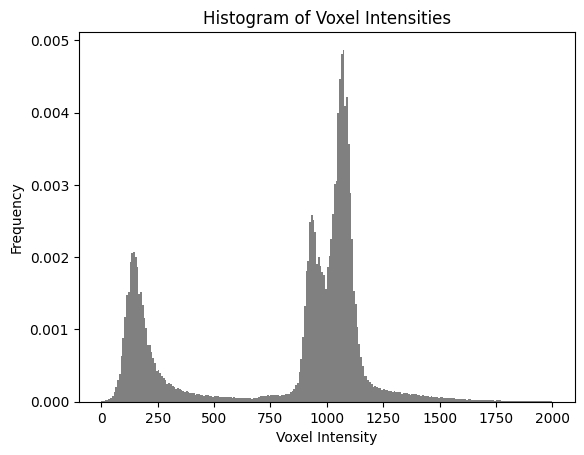

In [69]:
# Flatten the image to a 1D array
body_segmented_flattened = body_segmented.flatten()
body_segmented_flattened = body_segmented_flattened[body_segmented_flattened > 0]

# Plot the histogram
plt.hist(body_segmented_flattened, bins=256, range=(0, 2000), density=True, color='gray', alpha=1)
plt.title('Histogram of Voxel Intensities')
plt.xlabel('Voxel Intensity')
plt.ylabel('Frequency')
plt.show()

In [70]:
copd1_eBHCT = sitk.ReadImage(reference_image_path)

# convert the body segmented to sitk, so we can use the adaptive histogram equalization function
body_segmented_sitk = sitk.GetImageFromArray(body_segmented)
body_segmented_sitk.CopyInformation(copd1_eBHCT)

In [71]:
body_segmented_sitk_enahnced = clahe_3d(body_segmented_sitk, clip_limit=0.01)  
body_segmented_sitk_enahnced = sitk.GetArrayFromImage(body_segmented_sitk_enahnced)


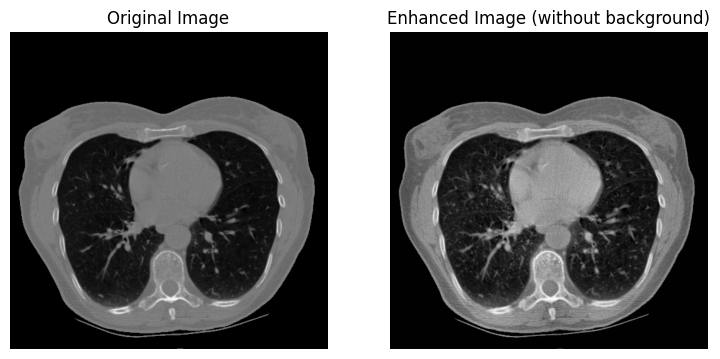

In [72]:
display_two_volumes(body_segmented, body_segmented_sitk_enahnced, 'Original Image', 'Enhanced Image (without background)', slice=70)

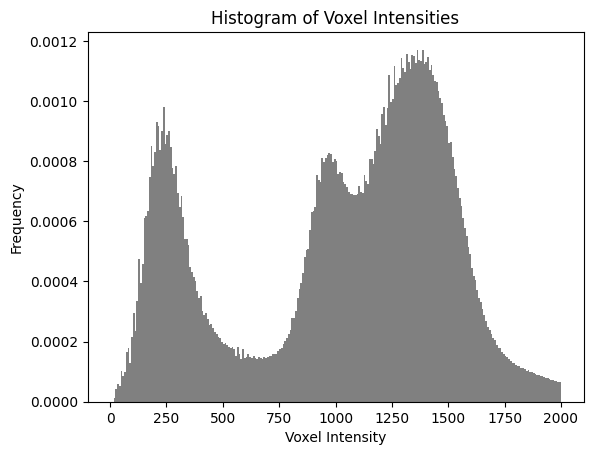

In [73]:
# Flatten the image to a 1D array
body_segmented_sitk_enahnced_flattened = body_segmented_sitk_enahnced.flatten()
body_segmented_sitk_enahnced_flattened = \
    body_segmented_sitk_enahnced_flattened[body_segmented_sitk_enahnced_flattened > 20]

# Plot the histogram
plt.hist(body_segmented_sitk_enahnced_flattened, bins=256, range=(0, 2000), density=True, color='gray', alpha=1)
plt.title('Histogram of Voxel Intensities')
plt.xlabel('Voxel Intensity')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# histogram_equalization
# https://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/70_Data_Augmentation.html

#### Pipeline

##### 1. Normalization

In [36]:
subject = 'copd1'

reference_image_path = os.path.join(os.getcwd(),f'../dataset/train/{subject}/{subject}_eBHCT.nii.gz')
copd1_eBHCT = sitk.ReadImage(reference_image_path)
copd1_eBHCT_img = sitk.GetArrayFromImage(copd1_eBHCT)

In [37]:
# Get the minimum and maximum intensity values of the input image
min_max_filter = sitk.MinimumMaximumImageFilter()
min_max_filter.Execute(copd1_eBHCT)

original_min = min_max_filter.GetMinimum()
original_max = min_max_filter.GetMaximum()

print(f'Original min: {original_min}, Original max: {original_max}')

Original min: -2000.0, Original max: 2672.0


In [38]:
# applying min-max normalization to the image
# note that the gantry and black background are still present and we need to remove them.

# segmenting the body and removing the gantry
mask, labeled_mask, largest_masks, body_segmented = \
    segment_body(copd1_eBHCT_img, threshold=700)

# inverging the largest masks to focus on the body for later steps
largest_masks_sitk = sitk.GetImageFromArray(largest_masks)
largest_masks_sitk.CopyInformation(copd1_eBHCT)

largest_masks_inverted = sitk.Not(largest_masks_sitk)

largest_masks_inverted = sitk.GetArrayFromImage(largest_masks_inverted)

In [39]:
# >> intermediate checkup
# convert the body segmented to sitk, so we can use the adaptive histogram equalization function
body_segmented_sitk = sitk.GetImageFromArray(body_segmented)
body_segmented_sitk.CopyInformation(copd1_eBHCT)

# Get the minimum and maximum intensity values of the body segmented
min_max_filter = sitk.MinimumMaximumImageFilter()
min_max_filter.Execute(body_segmented_sitk)

modified_min = min_max_filter.GetMinimum()
modified_max = min_max_filter.GetMaximum()

print(f'Original min: {modified_min}, Original max: {modified_max}')
print(f'np.unique(largest_masks): {np.unique(largest_masks)}')

Original min: 0.0, Original max: 2672.0
np.unique(largest_masks): [0 1]


In [40]:
# normalize the image using min-max normalization, excluding the gantry and black background using the largest mask that represents anything except the body
normalized_image = min_max_normalization(copd1_eBHCT_img, largest_masks_inverted).astype(np.int16)

# convert to sitk image
normalized_image_sitk = sitk.GetImageFromArray(normalized_image)
normalized_image_sitk.CopyInformation(copd1_eBHCT)

The maximum value for this volume int16 is: 32767


In [41]:
# denoising the image using bilateral filter
domain_sigma = 2.0
range_sigma = 50.0 

filtered_sitk = bilateral_filter_3d(normalized_image_sitk, domain_sigma, range_sigma)
filtered_image = sitk.GetArrayFromImage(filtered_sitk)

In [42]:
# contrast enhancment using adaptive histogram equalization
final_processed_sitk = clahe_3d(filtered_sitk, clip_limit=0.01)
final_processed_img = sitk.GetArrayFromImage(final_processed_sitk)

In [43]:
print(final_processed_sitk.GetPixelIDTypeAsString())

64-bit float


In [44]:
final_processed_sitk_int16 = sitk.Cast(final_processed_sitk, sitk.sitkInt16)
final_processed_img_int16 = sitk.GetArrayFromImage(final_processed_sitk_int16)

In [45]:
print(final_processed_sitk_int16.GetPixelIDTypeAsString())
print(final_processed_sitk_int16.GetPixelIDValue())
print(final_processed_sitk_int16.GetSize())

16-bit signed integer
2
(512, 512, 121)


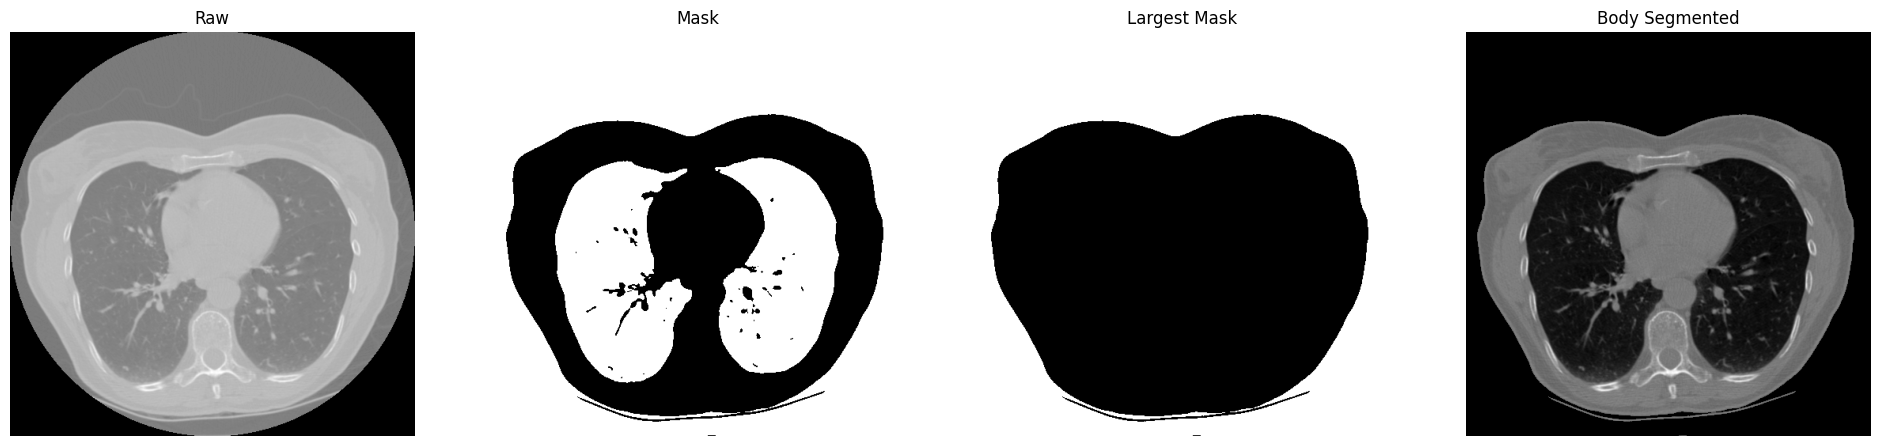

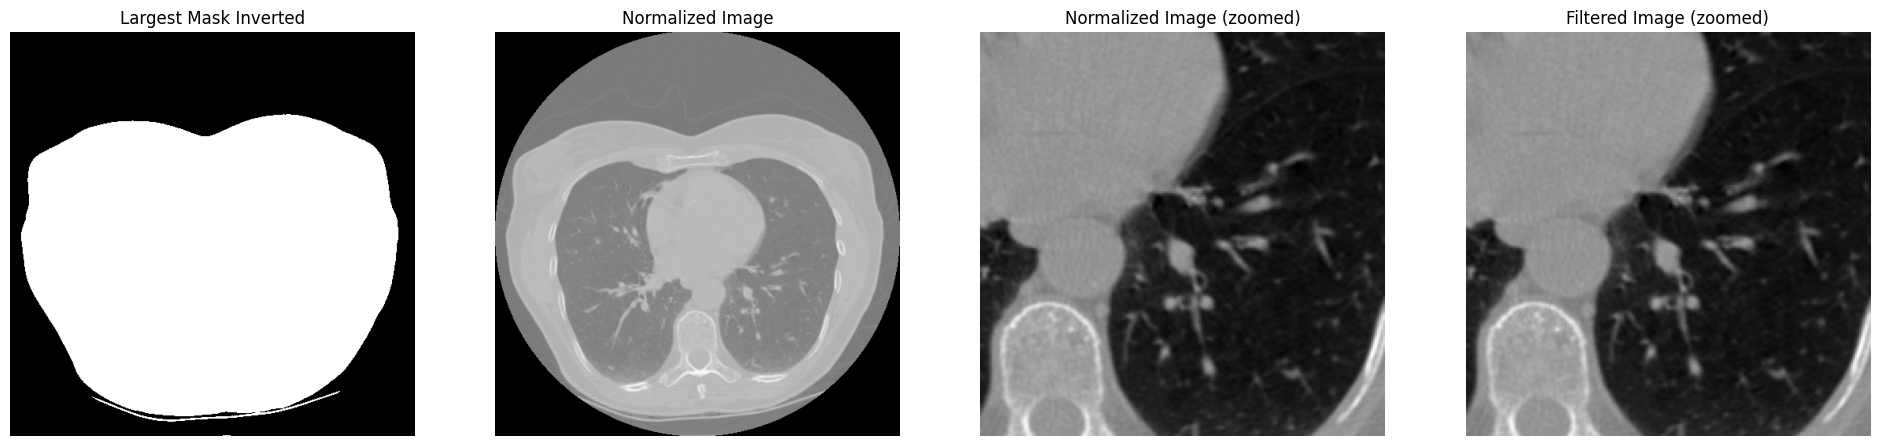

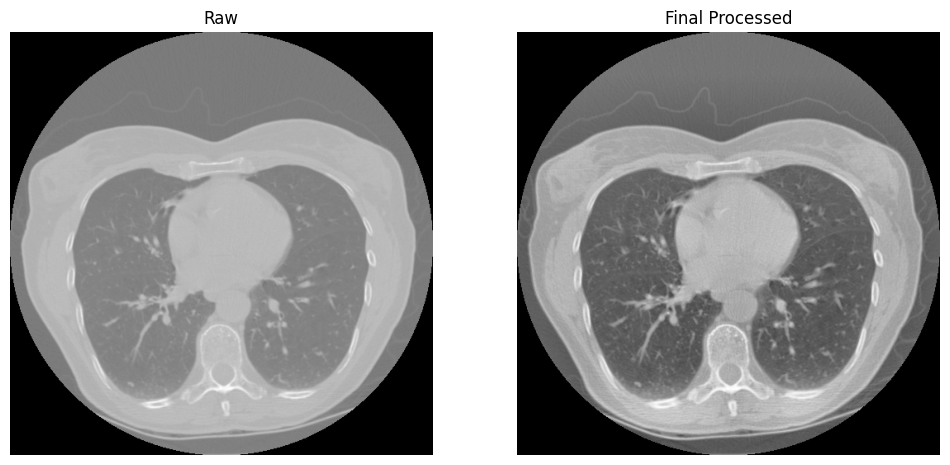

In [46]:
display_volumes(
    copd1_eBHCT_img, 
    mask,
    largest_masks,
    body_segmented,
    title1='Raw', 
    title2='Mask',
    title3='Largest Mask',
    title4='Body Segmented',
    slice1 = 70,
    slice2 = 70,
    slice3 = 70,
    slice4 = 70)

display_volumes(
    largest_masks_inverted,
    normalized_image,
    normalized_image[:, 220:420, 220:420],
    filtered_image[:, 220:420, 220:420],
    title1='Largest Mask Inverted',
    title2='Normalized Image',
    title3='Normalized Image (zoomed)',
    title4='Filtered Image (zoomed)',
    slice1 = 70,
    slice2 = 70,
    slice3 = 70,
    slice4 = 70)

display_volumes(
    copd1_eBHCT_img, 
    final_processed_img_int16,
    title1='Raw',
    title2='Final Processed',
    slice1 = 70,
    slice2 = 70)

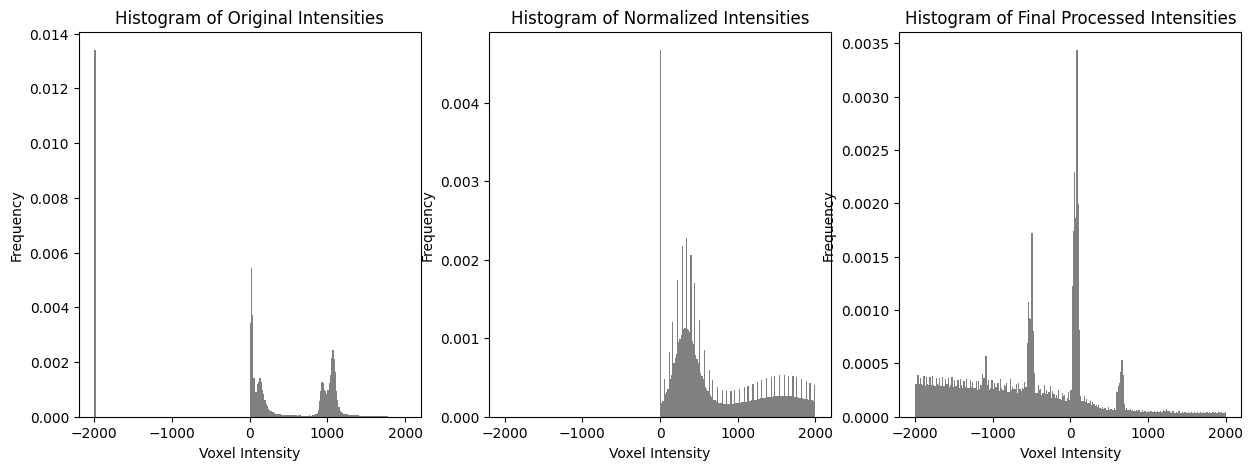

In [47]:
# Plot the histogram
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(copd1_eBHCT_img.flatten(), bins=256, range=(-2000, 2000), density=True, color='gray', alpha=1)
plt.title('Histogram of Original Intensities')
plt.xlabel('Voxel Intensity')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(normalized_image.flatten(), bins=256, range=(-2000, 2000), density=True, color='gray', alpha=1)
plt.title('Histogram of Normalized Intensities')
plt.xlabel('Voxel Intensity')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(final_processed_img.flatten(), bins=256, range=(-2000, 2000), density=True, color='gray', alpha=1)
plt.title('Histogram of Final Processed Intensities')
plt.xlabel('Voxel Intensity')
plt.ylabel('Frequency')

plt.show()